# Calculate the surface air temperature anomaly for 2020 with a reference period from 1990 - 2010

The surface air anomaly is the difference from a reference temperature. It indicates where a temperature differs from the selected reference.

In this example the surface temperature data from ECMWF ERA5 is used. The average surface air temperature of 2020 is compared to the average temperature of the years 1990 to 2010.

## Setup the notebook to use Geo Engine and generate plots

Import required python modules.

In [11]:
import geoengine as ge
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (30,12)

 Initialize Geo Engine and connect to it (running on local host).

In [12]:
ge.initialize("http://localhost:3030")


## Define methods to generate Geo Engine workflows

This method generates a workflow that loads raster data.

In [13]:
def raster_source_workflow(dataset_id):
  return {
  'type': 'Raster',
  'operator': {
    'type': 'GdalSource',
      'params': {
        'dataset': {
          'type': 'internal',
          'datasetId': dataset_id
        }
      }
    }
  }    



This method generates a workflow to aggregate all raster data in a window over time. It takes a time-series as input and produces a new time series-with the selected step size.

In [14]:
def temporal_aggregation_workflow(source, aggregation_type='mean', ignoreNoData=True, granularity='Years', step=1):
  return {
    'type': 'Raster',
    'operator': {
      'type': 'TemporalRasterAggregation',
      'params': {
        'aggregation': {
          'type': aggregation_type,
          'ignoreNoData': ignoreNoData
          },
          'window': {
            'granularity': granularity,
            'step': step
          }
        },
      'sources': {
        'raster': source['operator']
      }
    }
  }

## Generate and register workflows

This is the dataset id of the ECMWF ERA5 surace temperature data in Geo Engine.

In [15]:
era5_2m_temperature_dataset_id = '0b8382eb-fee0-497f-b7da-dd8c3d36f8f7'

Generate a workflow to load this dataset.

In [16]:
era5_2m_temp_workflow_def = raster_source_workflow(era5_2m_temperature_dataset_id)

Register the workflow with the engine. It also checks that the source is valid.

In [17]:
era5_2m_temp_workflow = ge.register_workflow(era5_2m_temp_workflow_def)

Generate a workflow to request yearly aggregates.

In [18]:
yearly_data_workflow_def = temporal_aggregation_workflow(era5_2m_temp_workflow_def, step=1)

Register it to use it in the next step.

In [19]:
yearly_data_workflow = ge.register_workflow(yearly_data_workflow_def)

Generate a workflow to request 20 year aggregates.

In [20]:
twenty_year_data_workflow_def = temporal_aggregation_workflow(era5_2m_temp_workflow_def, step=20)

Register it to use it in the next step.

In [21]:
twenty_year_data_workflow = ge.register_workflow(twenty_year_data_workflow_def)

## Request data for areas and time intervals

The reference data time-series is requested for a single time interval spanning 20 years

In [22]:
reference_start = datetime.strptime('1980-01-01T00:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")
reference_end = datetime.strptime('2010-01-01T00:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

We request the whole world in EPSG:4326 projection and a pixel resolution of 0.25°.

In [23]:
query_rectangle_reference = ge.QueryRectangle(
    [-180.,-90.,180.,90.],
    [reference_start, reference_end],
    srs= "EPSG:4326",
    resolution=[0.25,0.25]
    )



The year of interest is also defined as time interval

In [24]:
year_start = datetime.strptime('2020-01-01T00:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")
year_end = datetime.strptime('2021-01-01T00:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

The request will cover the same area with the same resolution. 

In [25]:
query_rectangle_year = ge.QueryRectangle(
    [-180.,-90.,180.,90.],
    [year_start, year_end],
    srs= "EPSG:4326",
    resolution=[0.25,0.25]
    )

## Query the data

`get_array()` starts the processing and stores the result as one numpy array.

This call callculates the 20 year average.

In [26]:
twenty_year_average_data = twenty_year_data_workflow.get_array(query_rectangle_reference)

This call callculates the 1 year average.

In [27]:
one_year_average_data = yearly_data_workflow.get_array(query_rectangle_year)

## Calculate the temperature anomaly for 2020

The Geo Engine generated average temperature values for the selected time intervals. Calculate the difference to display the anomaly.

In [28]:
temperature_anomaly = one_year_average_data - twenty_year_average_data 

Define a good color map ...

In [29]:
cmap = plt.cm.get_cmap('coolwarm', 14)
boundaries = [-7, -5, -3, -2, -1, -0.5, 0, 0.5, 1, 2, 3, 5, 7]
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N, clip=True)


... and plot

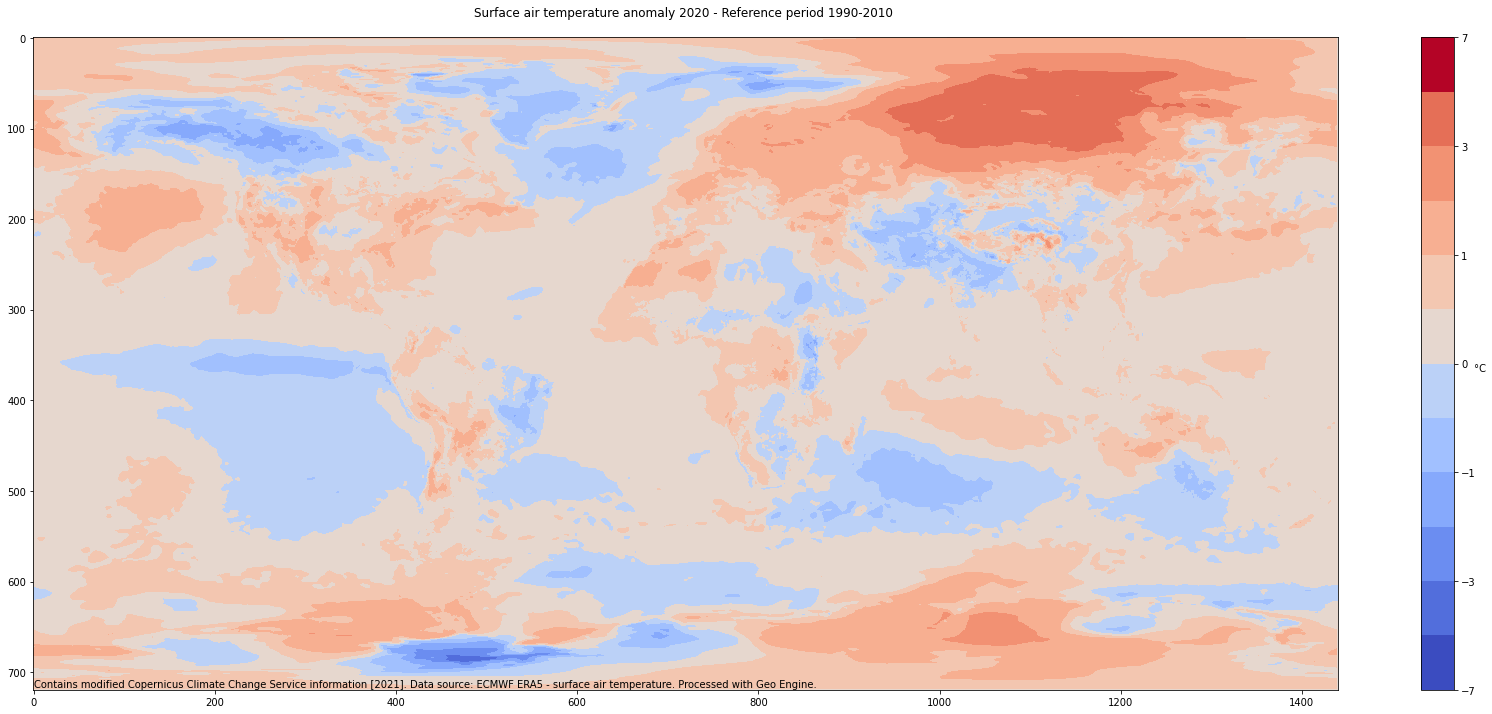

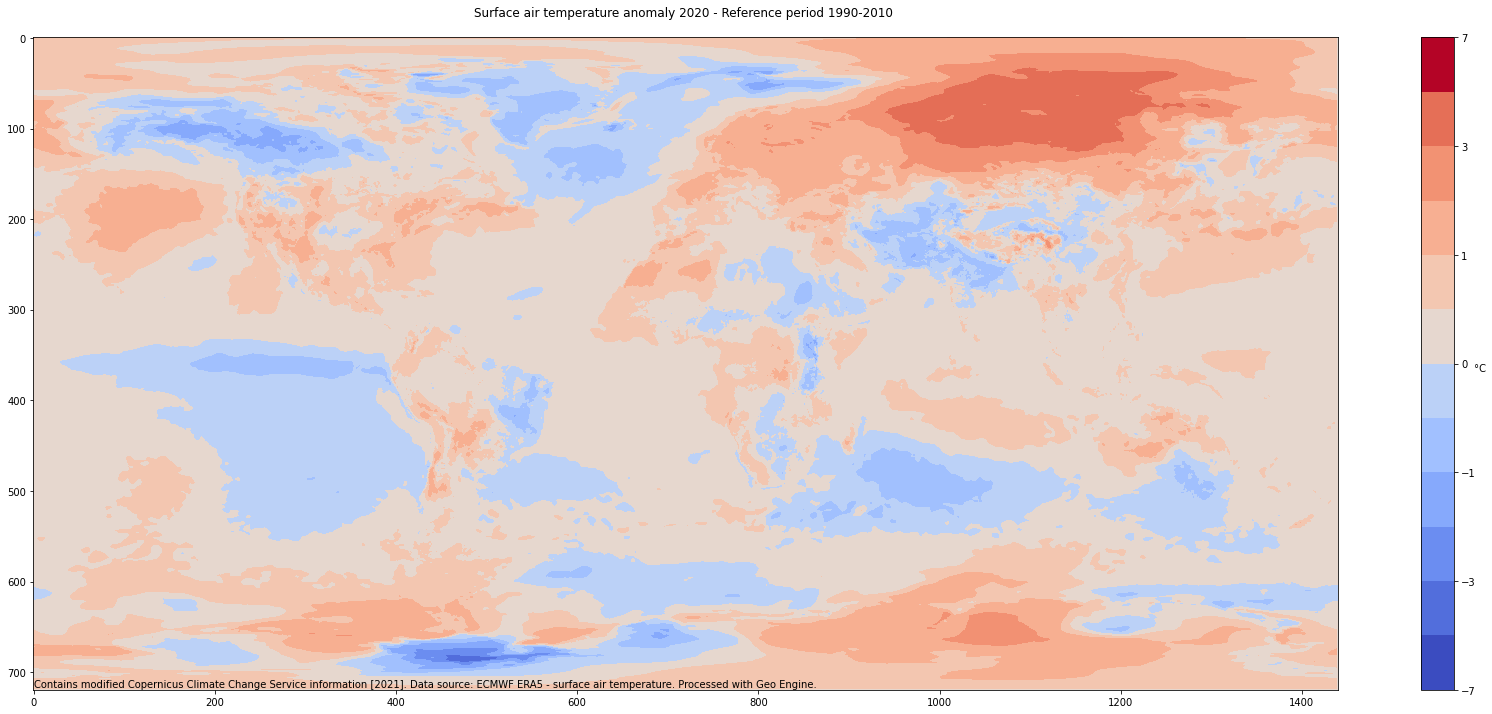

In [33]:
fig0, ax0 = plt.subplots()
img0 = ax0.imshow(temperature_anomaly, cmap=cmap, norm=norm)
cbar = fig0.colorbar(img0)
cbar.set_label('°C', rotation=0)
ax0.set_title('Surface air temperature anomaly 2020 - Reference period 1990-2010 \n ')
ax0.text(0.001, 0.001,'Contains modified Copernicus Climate Change Service information [2021]. Data source: ECMWF ERA5 - surface air temperature. Processed with Geo Engine.',         horizontalalignment='left',
        verticalalignment='bottom', transform=ax0.transAxes)
# fig0.show()

fig0